# 🎨 Structured 2D+6D Model Visualization Notebook

**Dedicated Visualization for Pre-Trained Models**

This notebook is designed to load and visualize pre-trained 2D+6D structured autoencoders downloaded from cloud training.

## Key Features:
- **Load Pre-trained Models**: Quick loading from saved .pth files
- **Latent Space Grid Scan**: Interactive exploration of the 2D content latent space
- **Comprehensive Visualizations**: All available visualization functions
- **Affine Transformation Analysis**: Examine learned geometric transformations
- **No Training Required**: Pure visualization and analysis

## Model Architecture:
- **2D Content Latent**: Captures digit identity/shape clustering
- **6D Transform Latent**: Captures spatial transformations (rotation, skew, translation)
- **Simplified Loss**: Uses affine reconstruction + KL divergence on content latent

In [25]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns

# Explicit imports from modular structure
import structured_2d6d_autoencoder as s2d6d
import affine_autoencoder_shared as shared

# Import visualization functions
import structured_2d6d_visualization as viz

print("📚 All modules loaded successfully!")
print(f"PyTorch version: {torch.__version__}")
print(f"Device available: {torch.cuda.is_available() and 'CUDA' or 'CPU'}")

📚 All modules loaded successfully!
PyTorch version: 2.5.1
Device available: CPU


In [17]:
# 🔧 CONFIGURATION
# Set up basic configuration for visualization
VIZ_CONFIG = {
    'force_cuda': False,  # Set to True if you want GPU
    'batch_size_test': 128,
    'data_dir': '../data',
    'pin_memory': True,
    'num_workers': 4,
    'grid_size': 30,  # For latent space grid scan
    'latent_range': 3.0,  # Range for latent space scanning (-range to +range)
    'figure_dpi': 100,
    'save_plots': False  # Set to True to save plot images
}

# Get device and data loaders
device = shared.get_cloud_device(VIZ_CONFIG) if VIZ_CONFIG['force_cuda'] else torch.device('cpu')
print(f"🖥️ Using device: {device}")

# Load test data for visualization
_, test_loader = shared.get_cloud_mnist_loaders(**{k: v for k, v in VIZ_CONFIG.items() 
                                                   if k in ['batch_size_test', 'data_dir', 'pin_memory', 'num_workers']})
print("📊 Test data loaded successfully!")

🖥️ Using device: cpu
📊 Train batches: 235, Test batches: 79
📊 Test data loaded successfully!


In [18]:
# 📁 LOAD YOUR PRE-TRAINED MODEL
# Update the model_path with your downloaded model file

# Option 1: Load specific model by filename (RECOMMENDED)
model_path = '/Users/pmaksym/Library/CloudStorage/Box-Box/Code/adversAE/adversae/vae_training/affine/unified_8d_vae_unified_8d_vae_20250722_023104.pth'  # Update this path!

try:
    # Try the standard loading function first (if available)
    if hasattr(shared, 'load_model_cloud'):
        model, original_config, device = shared.load_model_cloud(model_path)
        
        # For backward compatibility, extract additional data
        viz_data = {
            'config': original_config,
            'timestamp': 'loaded',
            'model_type': 'StructuredAffineInvariantAutoEncoder',
            'losses': {},
            'extra_data': {}
        }
        losses_dict = {}
        extra_data = {}
        
        print(f"✅ Model loaded successfully!")
        print(f"📅 Loaded from: {model_path}")
        print(f"🏗️ Model type: Structured Affine Autoencoder")
        print(f"⚙️ Content dim: {original_config.get('content_latent_dim', 2)}")
        print(f"⚙️ Transform dim: {original_config.get('transform_latent_dim', 6)}")
        
        model_loaded = True
    else:
        # If shared.load_model_cloud doesn't exist, go directly to manual loading
        raise AttributeError("load_model_cloud not found")
        
except (FileNotFoundError, AttributeError) as e:
    if isinstance(e, FileNotFoundError):
        print(f"❌ Model file not found: {model_path}")
        print("💡 Please update the model_path variable with the correct path to your .pth file")
        print("💡 Available files in current directory:")
        import os
        pth_files = [f for f in os.listdir('.') if f.endswith('.pth')]
        for f in pth_files[:10]:  # Show first 10 .pth files
            print(f"   - {f}")
        model_loaded = False
    else:
        print("💡 Using direct loading method...")
        
        try:
            # Manual loading with improved security
            checkpoint = torch.load(model_path, map_location=device, weights_only=False)
            
            # Extract config with defaults
            original_config = checkpoint.get('config', {
                'content_latent_dim': 2,
                'transform_latent_dim': 6,
                'total_latent_dim': 8
            })
            
            # Create model with correct parameters
            model = s2d6d.StructuredAffineInvariantAutoEncoder(
                content_dim=original_config.get('content_latent_dim', 2),
                transform_dim=original_config.get('transform_latent_dim', 6)
            ).to(device)
            
            # Load state dict
            model.load_state_dict(checkpoint['model_state_dict'])
            model.eval()
            
            # Setup other variables
            viz_data = {
                'config': original_config,
                'timestamp': checkpoint.get('timestamp', 'unknown'),
                'model_type': 'StructuredAffineInvariantAutoEncoder',
                'losses': checkpoint.get('losses', {}),
                'extra_data': checkpoint.get('extra_data', {})
            }
            losses_dict = viz_data['losses']
            extra_data = viz_data['extra_data']
            
            print(f"✅ Model loaded successfully!")
            print(f"⚙️ Content dim: {original_config['content_latent_dim']}")
            print(f"⚙️ Transform dim: {original_config['transform_latent_dim']}")
            print(f"📊 Model ready for visualization!")
            model_loaded = True
            
        except Exception as e2:
            print(f"❌ Loading failed: {e2}")
            print("💡 Please check:")
            print("   - File path is correct")
            print("   - File is a valid PyTorch model checkpoint")
            print("   - Model was saved with the correct structure")
            model_loaded = False

💡 Using direct loading method...
✅ Model loaded successfully!
⚙️ Content dim: 2
⚙️ Transform dim: 6
📊 Model ready for visualization!


In [26]:
# 🎯 QUICK MODEL SUMMARY
if model_loaded:
    viz.print_model_summary(model, losses_dict, original_config)
else:
    print("❌ Model not loaded. Please fix the model path in the previous cell.")

🔍 MODEL SUMMARY
📊 Total parameters: 2,323,793
🎛️ Trainable parameters: 2,323,793
🏃 Epochs trained: 0
⚙️ Alpha (affine weight): 1.0
⚙️ Beta (KL weight): 0.01
🎯 Simplified loss function: ✅

✅ Ready for visualization!


🎨 Creating latent space grid scan...


/Users/pmaksym/Library/CloudStorage/Box-Box/Code/adversAE/adversae/vae_training/affine/structured_2d6d_visualization.py:112: UserWarning: Glyph 128506 (\N{WORLD MAP}) missing from current font.
  plt.tight_layout()


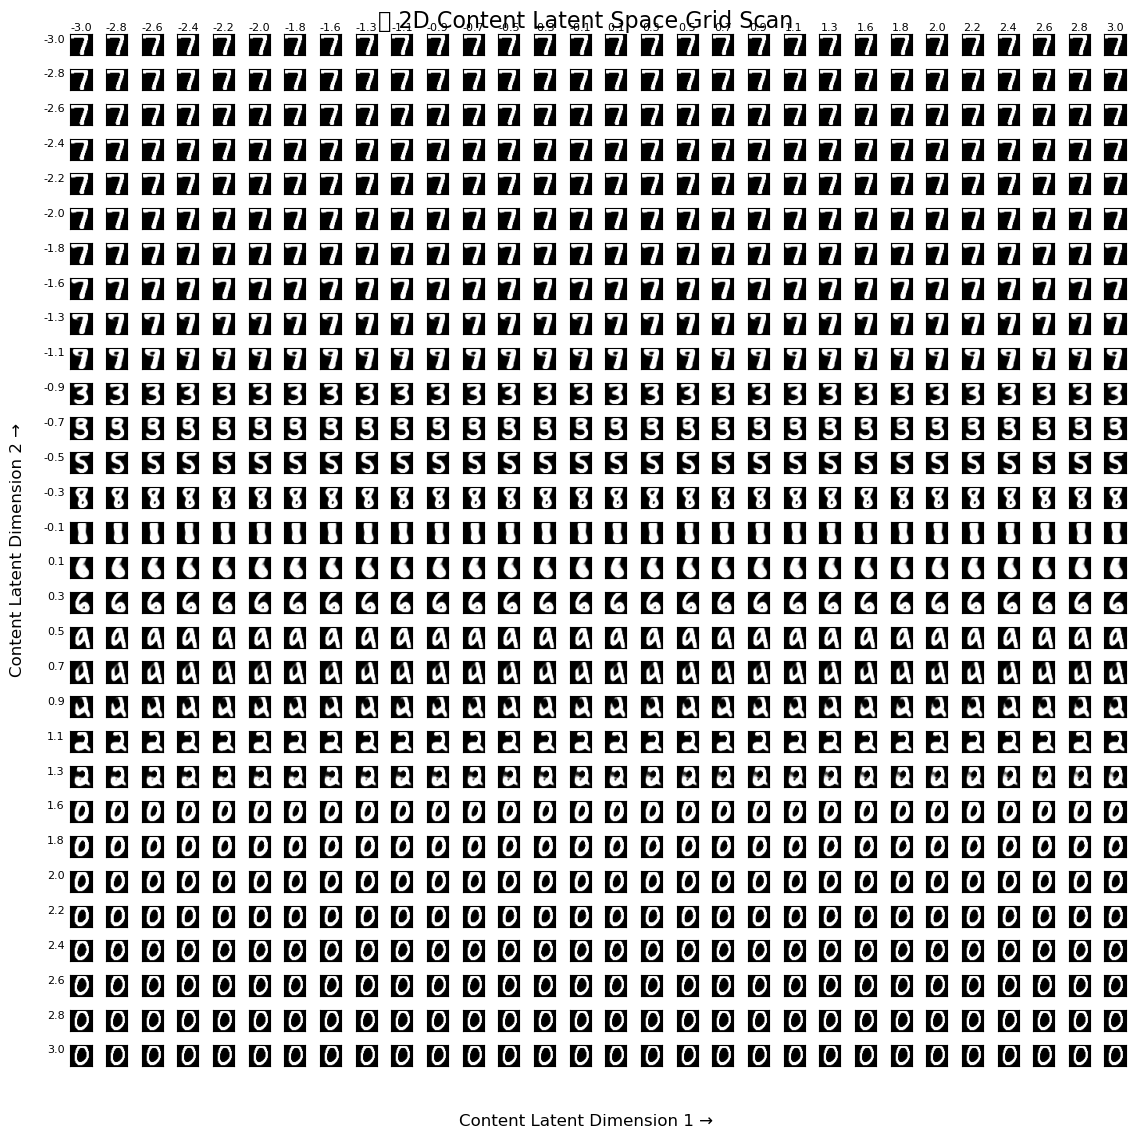

✅ Grid scan complete! Generated 30×30 = 900 images
📏 Scanned range: [-3.0, 3.0] in both dimensions


In [27]:
# 🌟 LATENT SPACE GRID SCAN - MAIN FEATURE
# This creates a grid of digits by scanning through the 2D content latent space

if model_loaded:
    print("🎨 Creating latent space grid scan...")
    
    # Create the grid using the visualization module
    grid_images, x_vals, y_vals = viz.create_latent_space_grid(
        model, device, 
        grid_size=VIZ_CONFIG['grid_size'], 
        latent_range=VIZ_CONFIG['latent_range']
    )
    
    # Plot the grid
    viz.plot_latent_space_grid(grid_images, x_vals, y_vals, 
                              VIZ_CONFIG['grid_size'], VIZ_CONFIG['latent_range'])

else:
    print("❌ Cannot create grid scan without loaded model.")

🎲 Analyzing random digit reconstructions...


/var/folders/ll/7kn2qpx13h3d33v8br6bk2gw0000gp/T/ipykernel_78829/2151871558.py:82: UserWarning: Glyph 127922 (\N{GAME DIE}) missing from current font.
  plt.tight_layout()


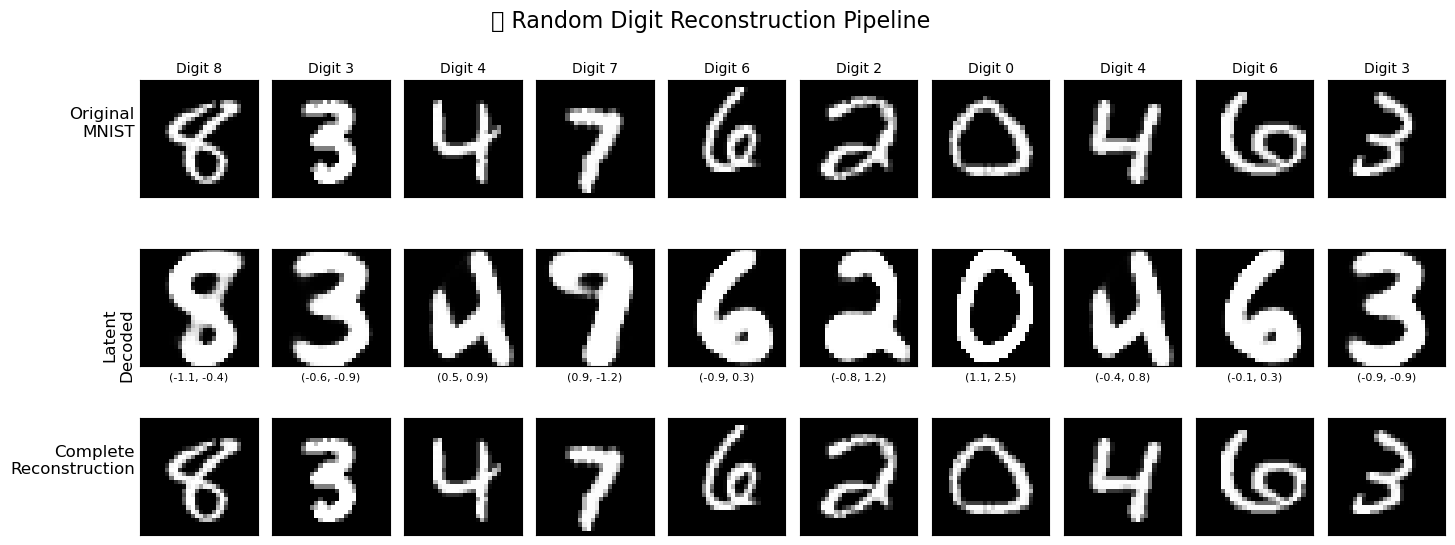


📊 RECONSTRUCTION QUALITY ANALYSIS:
Average Latent Reconstruction MSE: 1.1908
Average Complete Reconstruction MSE: 0.0000
Improvement from Affine Transform: 100.0%

🔢 PER-DIGIT ANALYSIS:
Digit 8: Content=(-1.10, -0.44), Latent MSE=1.1806, Complete MSE=0.0000
Digit 3: Content=(-0.63, -0.90), Latent MSE=1.4994, Complete MSE=0.0000
Digit 4: Content=(0.55, 0.86), Latent MSE=1.0536, Complete MSE=0.0000
Digit 7: Content=(0.93, -1.22), Latent MSE=1.2242, Complete MSE=0.0000
Digit 6: Content=(-0.92, 0.27), Latent MSE=1.0844, Complete MSE=0.0000
Digit 2: Content=(-0.78, 1.16), Latent MSE=1.1216, Complete MSE=0.0000
Digit 0: Content=(1.11, 2.51), Latent MSE=1.1137, Complete MSE=0.0000
Digit 4: Content=(-0.41, 0.80), Latent MSE=1.1693, Complete MSE=0.0000
Digit 6: Content=(-0.08, 0.27), Latent MSE=1.2517, Complete MSE=0.0000
Digit 3: Content=(-0.91, -0.86), Latent MSE=1.2096, Complete MSE=0.0000


In [ ]:
# 🎲 RANDOM DIGIT RECONSTRUCTION ANALYSIS
# Sample 10 random digits and show their complete reconstruction pipeline

if model_loaded:
    print("🎲 Analyzing random digit reconstructions...")
    viz.analyze_random_reconstructions(model, test_loader, device, num_samples=10)
else:
    print("❌ Cannot analyze reconstructions without loaded model.")

🔍 Running complete latent space analysis...
🔍 Running complete latent space analysis...

🔍 Diagnosing actual latent space distribution...
🔍 ACTUAL LATENT SPACE RANGES FOR EACH DIGIT:
Digit 0: Dim1 [-2.06, 2.30], Dim2 [1.17, 3.26]
Digit 1: Dim1 [-2.37, 3.01], Dim2 [-0.61, 0.12]
Digit 2: Dim1 [-2.09, 2.59], Dim2 [-2.80, 1.47]
Digit 3: Dim1 [-2.80, 2.31], Dim2 [-1.46, 0.75]
Digit 4: Dim1 [-2.42, 2.49], Dim2 [-1.35, 1.24]
Digit 5: Dim1 [-1.95, 2.09], Dim2 [-1.05, 0.27]
Digit 6: Dim1 [-1.89, 2.41], Dim2 [-0.36, 1.85]
Digit 7: Dim1 [-2.70, 2.50], Dim2 [-2.92, 0.96]
Digit 8: Dim1 [-2.13, 2.40], Dim2 [-1.17, 0.43]
Digit 9: Dim1 [-2.17, 3.09], Dim2 [-1.39, 0.73]

📊 OVERALL STATISTICS:
Full Range: Dim1 [-2.80, 3.09], Dim2 [-2.92, 3.26]
Mean: Dim1 -0.00, Dim2 -0.06
Std:  Dim1 0.97, Dim2 1.04

💡 SUGGESTED GRID SCAN RANGE: 3.6
   (This would scan [-3.6, 3.6] in both dimensions)
🔍 ACTUAL LATENT SPACE RANGES FOR EACH DIGIT:
Digit 0: Dim1 [-2.06, 2.30], Dim2 [1.17, 3.26]
Digit 1: Dim1 [-2.37, 3.01], D

/Users/pmaksym/Library/CloudStorage/Box-Box/Code/adversAE/adversae/vae_training/affine/structured_2d6d_visualization.py:215: UserWarning: Glyph 128506 (\N{WORLD MAP}) missing from current font.
  plt.tight_layout()


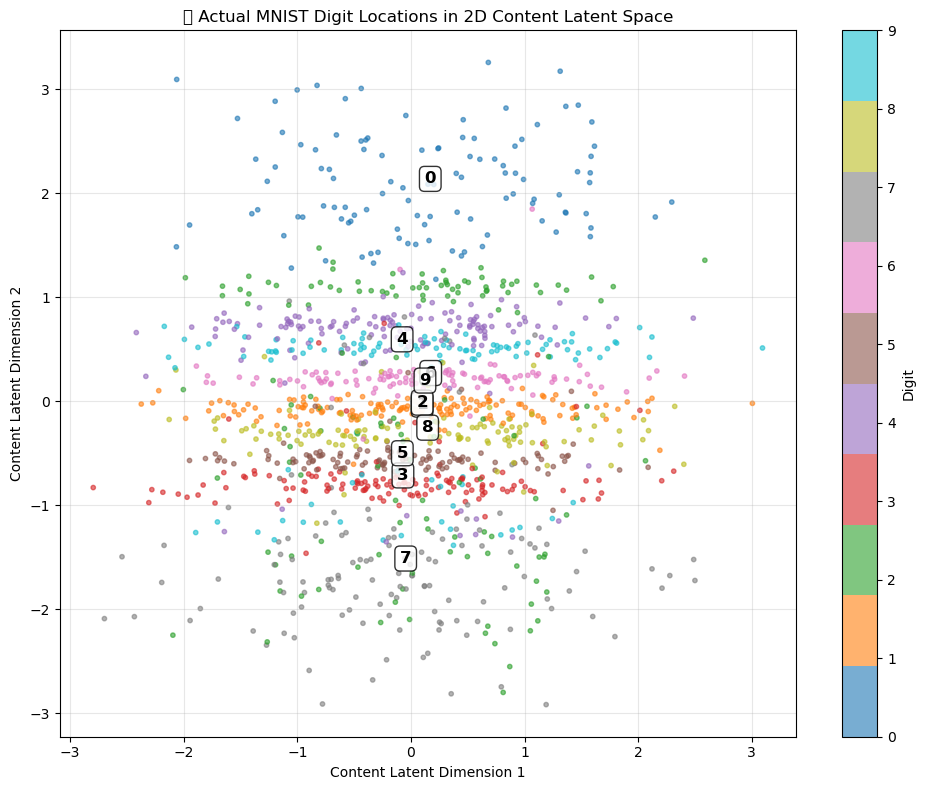


🔧 UPDATING GRID SCAN RANGE:
Current range: 3.0
Suggested range: 3.6

🎨 Creating latent space grid scan...


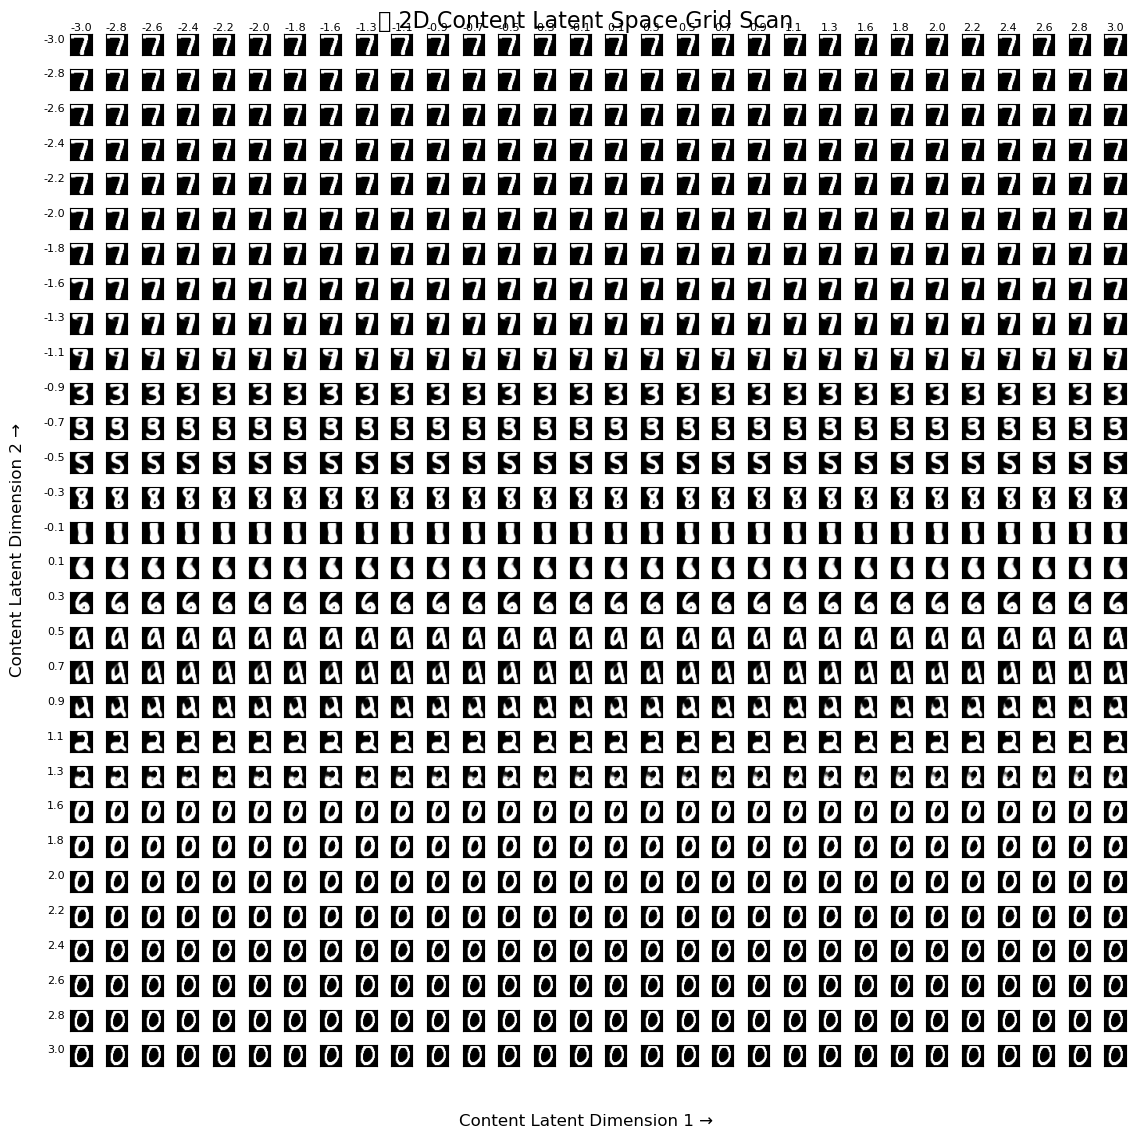

✅ Grid scan complete! Generated 30×30 = 900 images
📏 Scanned range: [-3.0, 3.0] in both dimensions


In [28]:
# 🔍 COMPLETE LATENT SPACE ANALYSIS
# Run comprehensive latent space diagnostic and visualization

if model_loaded:
    print("🔍 Running complete latent space analysis...")
    content_data, labels, suggested_range = viz.run_complete_latent_analysis(
        model, test_loader, device, VIZ_CONFIG
    )
    
    # Update config with suggested range if desired
    # VIZ_CONFIG['latent_range'] = suggested_range
    
else:
    print("❌ Cannot run latent analysis without loaded model.")